In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
from numpy import vectorize

In [2]:
plt.style.use('fivethirtyeight')

SQL

In [44]:
# FT1 23.04% - CTP selftest
CTP_selftest_query = """ 
SELECT [TblFinal].[tDateTime]
      ,[TblFinal].[StationID]
      ,[TblFinal].[SerialNumber]
      ,[ProductName]
      ,[Version]
      ,[ExeInfo]
      ,[Item152]
      ,[Item152St]
      ,[SO]
      ,[Job_GPN]
  FROM [ate_db_tblfinal_new].[dbo].[TblFinal]

  LEFT JOIN TblFinal2 on TblFinal.SerialNumber = TblFinal2.SerialNumber

  WHERE ItemNameType = '15688'
  and TblFinal.tDateTime > '2022-08-24 01:48:42'
  /*and TblFinal.tDateTime BETWEEN '2022-08-24 01:48:42' and '2022-08-25 06:21:49'*/
  and Item152St in ('0','1')
  order by tDateTime ASC
"""

VEXT_query = """
SELECT top(2000)[TblFinal].[tDateTime]
      ,[Item180] as 'BatteryVol'
      ,[Item207] as 'VEXTcurrent'
      ,[Item207St] as 'VEXTcurrentSt'
      ,[ExeInfo]
      ,[TblFinal].[StationID]
      ,[TblFinal].[SerialNumber]
      ,[ProductName]
      ,[Version]
      ,[SO]
      ,[Job_GPN]
  FROM [ate_db_tblfinal_new].[dbo].[TblFinal]

  LEFT JOIN TblFinal2 on TblFinal.SerialNumber = TblFinal2.SerialNumber

  WHERE ItemNameType = '15689' 
  and TblFinal.tDateTime BETWEEN '2022-07-01' and '2022-09-06 05:16:17'
  order by BatteryVol DESC
"""

Motor_query = """
SELECT [tDateTime]
      ,[ItemNameType]
      ,[StationID]
      ,[SerialNumber]
      ,[ProductName]
      ,[Item58]
      ,[Item58St]
      ,[SO]
      ,[Job_GPN]
  FROM [ate_db_tblcpu].[dbo].[TblCpu]
  WHERE ItemNameType = 15545
  and tDateTime BETWEEN '2022-08-11 10:56:50' and '2022-08-22 02:42:58'
  and Item58St in ('0','1')
  ORDER BY tDateTime ASC
"""

Click_query = """
SELECT [tDateTime]
      ,[SerialNumber]
      ,Item7 as 'Button1_ClickRatio'
      ,Item17 as 'Button2_ClickRatio'
      ,Item27 as 'Button3_ClickRatio'
      ,Item37 as 'Button4_ClickRatio'
      ,Item38 as 'Button4_Stroke'
      ,Item47 as 'Button5_ClickRatio'
      ,result
      ,failitem
      ,[ProductName]
      ,[Version]
      ,[StationID]
      ,[ExeInfo]
      ,[SO]
      ,[Job_GPN]
  FROM [ate_db_tblfinal_new].[dbo].[TblFinal]

  WHERE ItemNameType = '12434' 
  and tDateTime BETWEEN '2022-08-27 00:21:20' and '2022-09-01 06:55:27'
  order by tDateTime ASC
"""

airtight_query="""
SELECT [tDateTime]
      ,[SerialNumber]
      ,[result]
      ,[failitem]
      ,[ProductName]
      ,[Version]
      ,[StationID]
      ,[ExeInfo]
      ,[SO]
      ,[Job_GPN]
  FROM [ate_db_tblfinal_new].[dbo].[TblFinal]

  WHERE ItemNameType = '8837' 
  and tDateTime BETWEEN '2022-08-23' and '2022-09-07'
  and Job_GPN like '010-02648-__'
  order by tDateTime ASC
"""

tblfinal

In [45]:
tblfinal = "DRIVER={SQL Server};SERVER=ATE_SERVER;DATABASE=ate_db_tblfinal_new;UID=ate_oper;PWD=ate.oper"
tblfinal_engine = create_engine(URL.create("mssql+pyodbc", query={"odbc_connect": tblfinal}))

CTP_selftest = pd.read_sql(CTP_selftest_query, tblfinal_engine)
VEXT = pd.read_sql(VEXT_query, tblfinal_engine)
click = pd.read_sql(Click_query, tblfinal_engine)
airtight = pd.read_sql(airtight_query, tblfinal_engine)


tblcpu

In [5]:
tblcpu = "DRIVER={SQL Server};SERVER=ATE_SERVER;DATABASE=ate_db_tblcpu;UID=ate_oper;PWD=ate.oper"
tblfinal_engine = create_engine(URL.create("mssql+pyodbc", query={"odbc_connect": tblcpu}))

Motor = pd.read_sql(Motor_query, tblfinal_engine)
#Motor_after0822 = pd.read_sql(Motor_query_after0822, tblfinal_engine)

Top1 FT2 23.91% - VEXT Current(charging) 6.43%

In [6]:
VEXT = VEXT[VEXT.VEXTcurrent > 0]

Text(4.28, 350, '4.275')

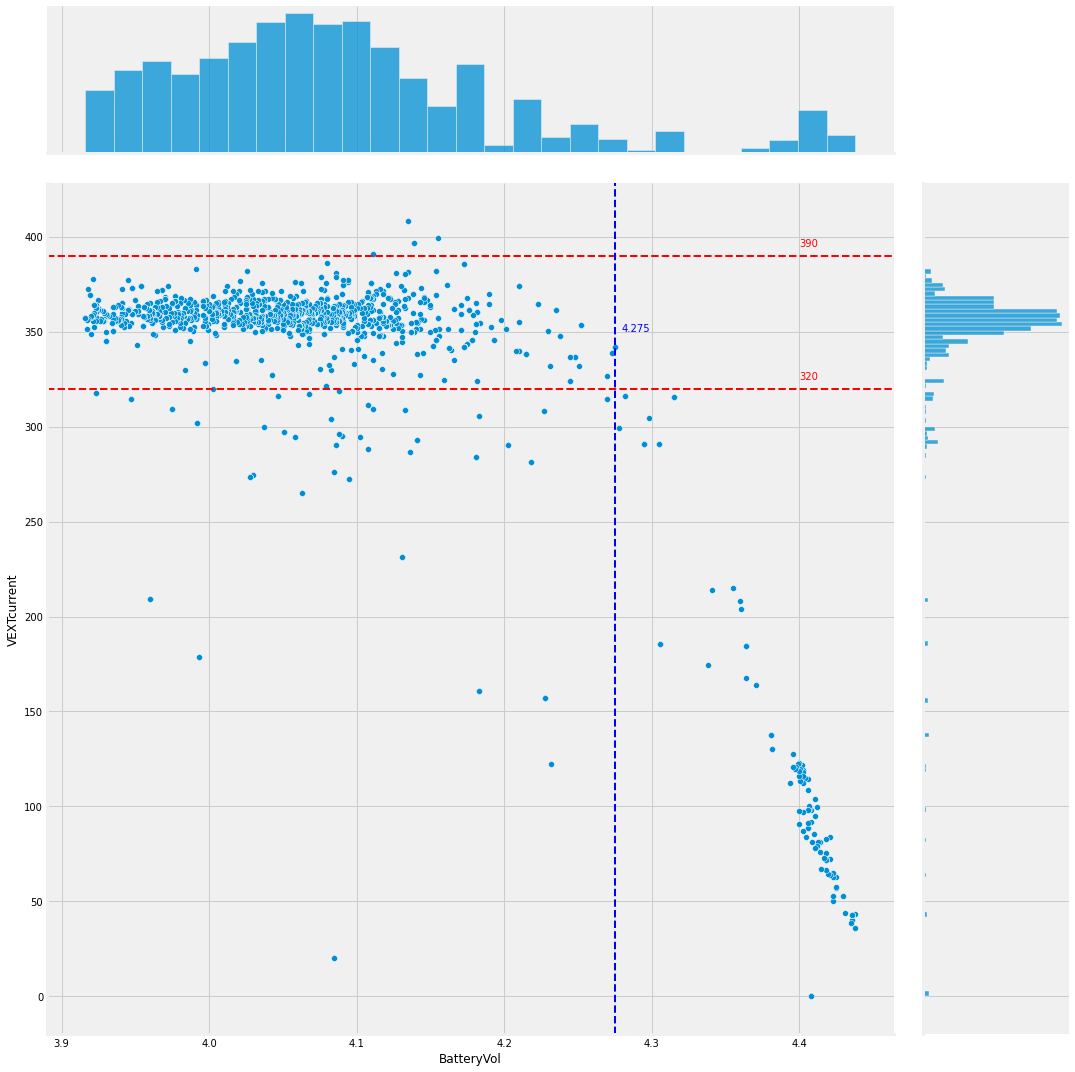

In [7]:
plot = sns.jointplot(data=VEXT, x='BatteryVol', y='VEXTcurrent', kind='scatter', height=15)
plot.ax_joint.axhline(y=320, ls='--', color='r', lw=2)
plot.ax_joint.text(s='320', y=325, x=4.4, color='red')
plot.ax_joint.axhline(y=390, ls='--', color='r', lw=2)
plot.ax_joint.text(s='390', y=395, x=4.4, color='red')
plot.ax_joint.axvline(x=4.275, ls='--', lw=2, color='blue')
plot.ax_joint.text(s='4.275', y=350, x=4.280, color='blue')

In [8]:
VEXT[VEXT.VEXTcurrent>320]['BatteryVol'].max()

4.275

Top2 FT1 23.04% - CTP selftest 12.91%

In [9]:
CTP_selftest.drop_duplicates(inplace=True)

In [10]:
CTP_selftest['TestProgramVersion'] = CTP_selftest.ExeInfo.apply(lambda x : x.split(' ')[3])

In [11]:
CTP_selftest_0 = CTP_selftest[CTP_selftest.Item152St == 0].copy()

In [12]:
CTP_selftest_0['8192St'] = CTP_selftest_0.Item152.apply(lambda value : 8192 if value == 8192 else 0)

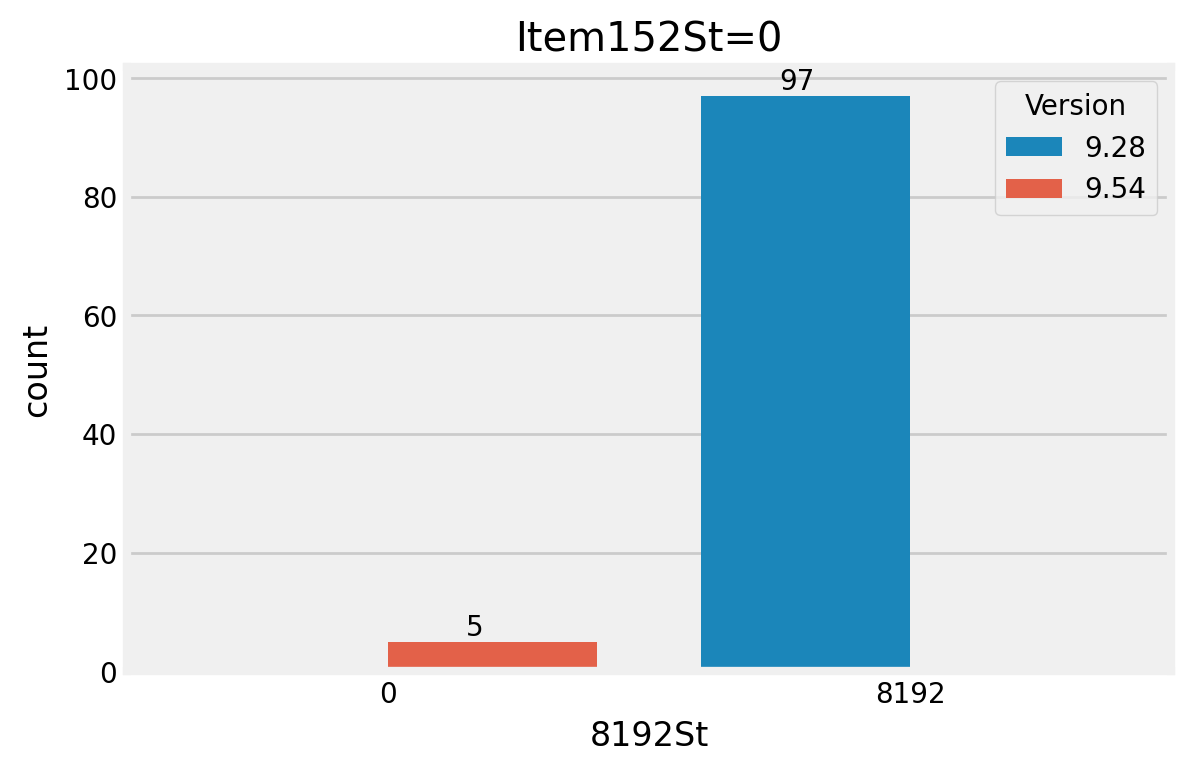

In [13]:
plt.figure(dpi=200)
ax = sns.countplot(data=CTP_selftest_0, x='8192St', hue='Version')
plt.title('Item152St=0')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

Top3 AutoATE 22.51% - Motor Resonant Frequency 7.22%

In [14]:
Motor.head()

,tDateTime,ItemNameType,StationID,SerialNumber,ProductName,Item58,Item58St,SO,Job_GPN
0,2022-08-16 07:34:04.283,15545,1,3428300979,MARQ ATHLETE GEN2 V09.28,218.4599,1,16017746,012-04263-05
1,2022-08-16 07:36:29.737,15545,3,3428300990,MARQ ATHLETE GEN2 V09.28,210.7482,1,16017746,012-04263-05
2,2022-08-16 08:08:09.957,15545,1,3428300981,MARQ ATHLETE GEN2 V09.28,209.0957,1,9999999,None
3,2022-08-16 08:08:45.443,15545,2,3428300989,MARQ ATHLETE GEN2 V09.28,219.9010,1,9999999,None
4,2022-08-16 08:09:12.760,15545,4,3428300991,MARQ ATHLETE GEN2 V09.28,201.7146,1,9999999,None


<AxesSubplot:ylabel='Density'>

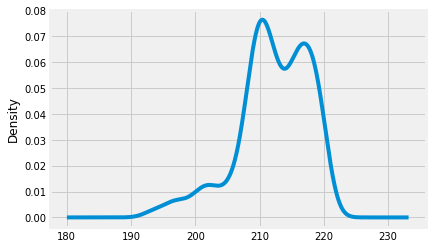

In [15]:
Motor.loc[Motor.Item58St==1,'Item58'].plot.kde()
# This motor's frequency mean value is 210

In [16]:
NG_ESN = Motor.loc[Motor.Item58St == 0,'SerialNumber'].unique()

In [17]:
Motor_retry = Motor[Motor.SerialNumber.isin(NG_ESN)].sort_values(['SerialNumber','tDateTime'], ascending=True)
Motor_retry = Motor_retry[Motor_retry.SerialNumber != '3428300662']

In [18]:
Motor_retry_first = Motor_retry.drop_duplicates(subset='SerialNumber', keep='first')

In [19]:
Motor_retry_last = Motor_retry.drop_duplicates(subset='SerialNumber', keep='last')

Text(0.5, 1.0, 'NG_ESN(19units)_retry')

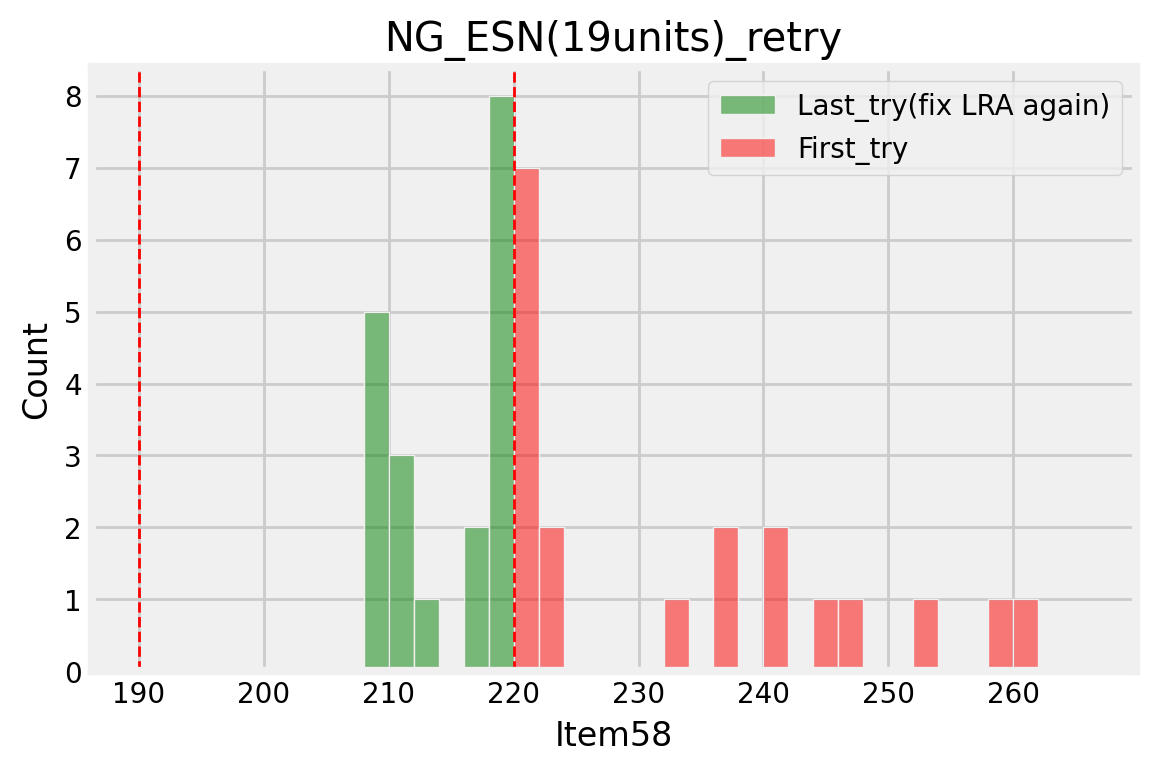

In [20]:
plt.figure(dpi=200)
ax = sns.histplot(data=Motor_retry_last['Item58'], binrange=[190,220],binwidth=2, color='green', alpha=0.5)
sns.histplot(data=Motor_retry_first['Item58'],binrange=[220,265],binwidth=2, color='red', alpha=0.5)
plt.legend(labels=['Last_try(fix LRA again)','First_try'])
plt.axvline(220, ls='--', color='red', lw=1)
plt.axvline(190, ls='--', color='red', lw=1)
plt.title('NG_ESN(19units)_retry')

Airtight_table - 95.88%

In [56]:
airtight.head()

,tDateTime,SerialNumber,result,failitem,ProductName,Version,StationID,ExeInfo,SO,Job_GPN
0,2022-08-23 06:40:48,3428300834,0,124,"MARQ Golfer Gen 2, NA",None,4,1.0.4.34,16017723,010-02648-20
1,2022-08-23 06:44:54,3416018256,0,122,"MARQ Golfer Gen 2, NA",None,4,1.0.4.34,16017723,010-02648-20
2,2022-08-23 06:49:09,3428300870,1,0,"MARQ Golfer Gen 2, NA",None,5,1.0.4.34,16017723,010-02648-20
3,2022-08-23 06:49:14,3428300839,1,0,"MARQ Golfer Gen 2, NA",None,6,1.0.4.34,16017723,010-02648-20
4,2022-08-23 06:49:20,3428300869,1,0,"MARQ Golfer Gen 2, NA",None,1,1.0.4.34,16017723,010-02648-20


In [64]:
airtight[airtight.duplicated(subset='SerialNumber', keep=False)].sort_values(['SerialNumber','tDateTime'], ascending=True)

,tDateTime,SerialNumber,result,failitem,ProductName,Version,StationID,ExeInfo,SO,Job_GPN
1,2022-08-23 06:44:54,3416018256,0,122,"MARQ Golfer Gen 2, NA",None,4,1.0.4.34,16017723,010-02648-20
7,2022-08-23 07:01:39,3416018256,1,0,"MARQ Golfer Gen 2, NA",None,5,1.0.4.34,16017723,010-02648-20
348,2022-08-25 05:41:53,3428300636,0,118,"MARQ Aviator Gen 2, NA",None,2,1.0.4.34,16017677,010-02648-00
354,2022-08-29 05:31:07,3428300636,1,0,"MARQ Aviator Gen 2, NA",None,2,1.0.4.34,16017677,010-02648-00
331,2022-08-25 04:26:05,3428300645,0,118,"MARQ Aviator Gen 2, NA",None,5,1.0.4.34,16017677,010-02648-00
...,...,...,...,...,...,...,...,...,...,...
259,2022-08-24 07:43:03,3428301026,0,124,"MARQ Athlete Gen 2, NA",None,2,1.0.4.34,16017730,010-02648-40
358,2022-08-29 05:53:32,3428301026,1,0,"MARQ Athlete Gen 2, NA",None,4,1.0.4.34,16017730,010-02648-40
258,2022-08-24 07:42:33,3428301072,0,117,"MARQ Athlete Gen 2, NA",None,3,1.0.4.34,16017730,010-02648-40
360,2022-08-29 06:05:38,3428301072,0,117,"MARQ Athlete Gen 2, NA",None,3,1.0.4.34,16017730,010-02648-40


In [67]:
airtight_dup = airtight[airtight.duplicated(subset='SerialNumber', keep=False)].sort_values(['SerialNumber','tDateTime'], ascending=True).drop_duplicates(subset='SerialNumber', keep='last')
airtight_dup

,tDateTime,SerialNumber,result,failitem,ProductName,Version,StationID,ExeInfo,SO,Job_GPN
7,2022-08-23 07:01:39,3416018256,1,0,"MARQ Golfer Gen 2, NA",None,5,1.0.4.34,16017723,010-02648-20
354,2022-08-29 05:31:07,3428300636,1,0,"MARQ Aviator Gen 2, NA",None,2,1.0.4.34,16017677,010-02648-00
353,2022-08-29 05:30:10,3428300645,1,0,"MARQ Aviator Gen 2, NA",None,4,1.0.4.34,16017677,010-02648-00
356,2022-08-29 05:35:40,3428300652,1,0,"MARQ Aviator Gen 2, NA",None,3,1.0.4.34,16017677,010-02648-00
371,2022-08-31 08:39:43,3428300667,1,0,"MARQ Athlete Gen 2, NA",None,6,1.0.4.34,16017730,010-02648-40
355,2022-08-29 05:34:49,3428300670,1,0,"MARQ Aviator Gen 2, NA",None,1,1.0.4.34,16017677,010-02648-00
372,2022-08-31 08:40:21,3428300678,1,0,"MARQ Athlete Gen 2, NA",None,5,1.0.4.34,16017730,010-02648-40
366,2022-08-30 06:10:10,3428300706,1,0,"MARQ Captain Gen 2, NA",None,4,1.0.4.34,16017720,010-02648-10
142,2022-08-23 10:59:35,3428300707,1,0,"MARQ Captain Gen 2, NA",None,5,1.0.4.34,16017720,010-02648-10
125,2022-08-23 10:32:16,3428300713,1,0,"MARQ Captain Gen 2, NA",None,1,1.0.4.34,16017720,010-02648-10


In [68]:
airtight_dup[airtight_dup.result == 0]

,tDateTime,SerialNumber,result,failitem,ProductName,Version,StationID,ExeInfo,SO,Job_GPN
94,2022-08-23 09:56:24,3428300717,0,124,"MARQ Captain Gen 2, NA",None,5,1.0.4.34,16017720,010-02648-10
350,2022-08-26 10:46:35,3428300792,0,117,"MARQ Adventurer Gen 2, EMEA",None,3,1.0.4.34,16017727,010-02648-31
79,2022-08-23 09:06:31,3428300793,0,129,"MARQ Adventurer Gen 2, EMEA",None,2,1.0.4.34,16017727,010-02648-31
362,2022-08-29 06:18:57,3428300798,0,118,"MARQ Adventurer Gen 2, SAm",None,5,1.0.4.34,16017729,010-02648-33
100,2022-08-23 10:01:36,3428300807,0,118,"MARQ Athlete Gen 2, EMEA",None,6,1.0.4.34,16017731,010-02648-41


Click final yield 86.77%

In [21]:
click.sort_values(['tDateTime','SerialNumber'], ascending=False, inplace=True)

In [22]:
click_drop = click.drop_duplicates(subset='SerialNumber', keep='first')

In [23]:
click_drop

,tDateTime,SerialNumber,Button1_ClickRatio,Button2_ClickRatio,Button3_ClickRatio,Button4_ClickRatio,Button4_Stroke,Button5_ClickRatio,result,failitem,ProductName,Version,StationID,ExeInfo,SO,Job_GPN
493,2022-09-01 06:55:27,3428300709,0.24,0.25,0.19,0.26,0.34,0.22,0,27,"Sub-Assy, Top Unit, Magna, Athlete",None,0,ClickTest,None,None
492,2022-09-01 06:49:37,3428301004,0.26,0.24,0.25,0.26,0.34,0.27,1,0,"Sub-Assy, Top Unit, Magna, Athlete",None,0,ClickTest,None,None
491,2022-09-01 06:47:48,3428301009,0.27,0.29,0.22,0.25,0.38,0.27,1,0,"Sub-Assy, Top Unit, Magna, Athlete",None,0,ClickTest,None,None
490,2022-09-01 06:45:44,3428300678,0.20,0.25,0.23,0.21,0.38,0.25,1,0,"MARQ Aviator Gen 2, NA",None,0,ClickTest,None,None
489,2022-09-01 06:43:58,3428300667,0.21,0.27,0.23,0.09,0.38,0.24,0,37,"MARQ Aviator Gen 2, NA",None,0,ClickTest,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,2022-08-27 01:15:51,3428300790,0.24,0.21,0.22,0.24,0.37,0.21,1,0,"MARQ Adventurer Gen 2, EMEA",None,0,ClickTest,None,None
7,2022-08-27 00:40:27,3428300703,0.26,0.24,0.24,0.22,0.45,0.22,1,0,"MARQ Aviator Gen 2, AUS/NZ/AFR",None,0,ClickTest,None,None
5,2022-08-27 00:35:35,3428300786,0.27,0.24,0.25,0.23,0.35,0.26,1,0,"MARQ Golfer Gen 2, EMEA",None,0,ClickTest,None,None
3,2022-08-27 00:31:23,3428300783,0.27,0.26,0.22,0.22,0.40,0.26,1,0,"MARQ Golfer Gen 2, EMEA",None,0,ClickTest,None,None


In [24]:
click_drop.failitem.value_counts()

0     358
7      25
27     11
37      7
18      2
47      2
17      2
8       2
48      1
28      1
Name: failitem, dtype: int64

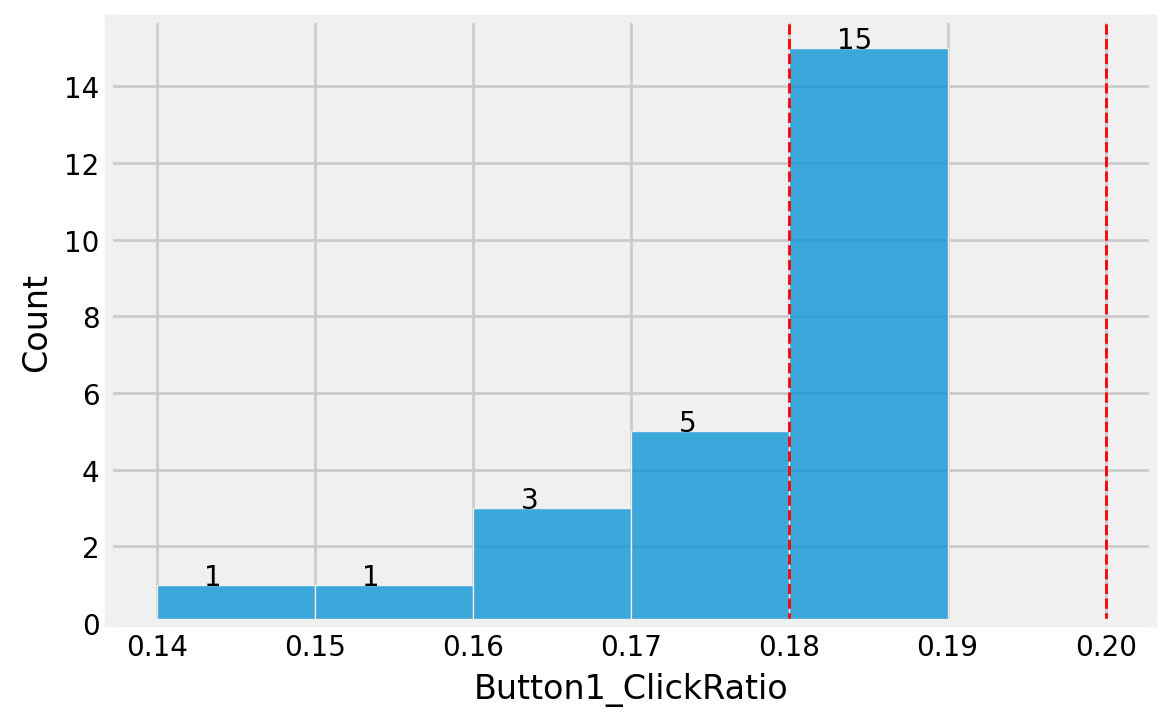

In [25]:
plt.figure(dpi=200)
ax = sns.histplot(data=click_drop[click_drop.failitem=='7'], x='Button1_ClickRatio', binwidth=0.01)
plt.axvline(0.2, color='red', ls='--', lw=1)
plt.axvline(0.18, color='red', ls='--',lw=1)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.003, p.get_height()))

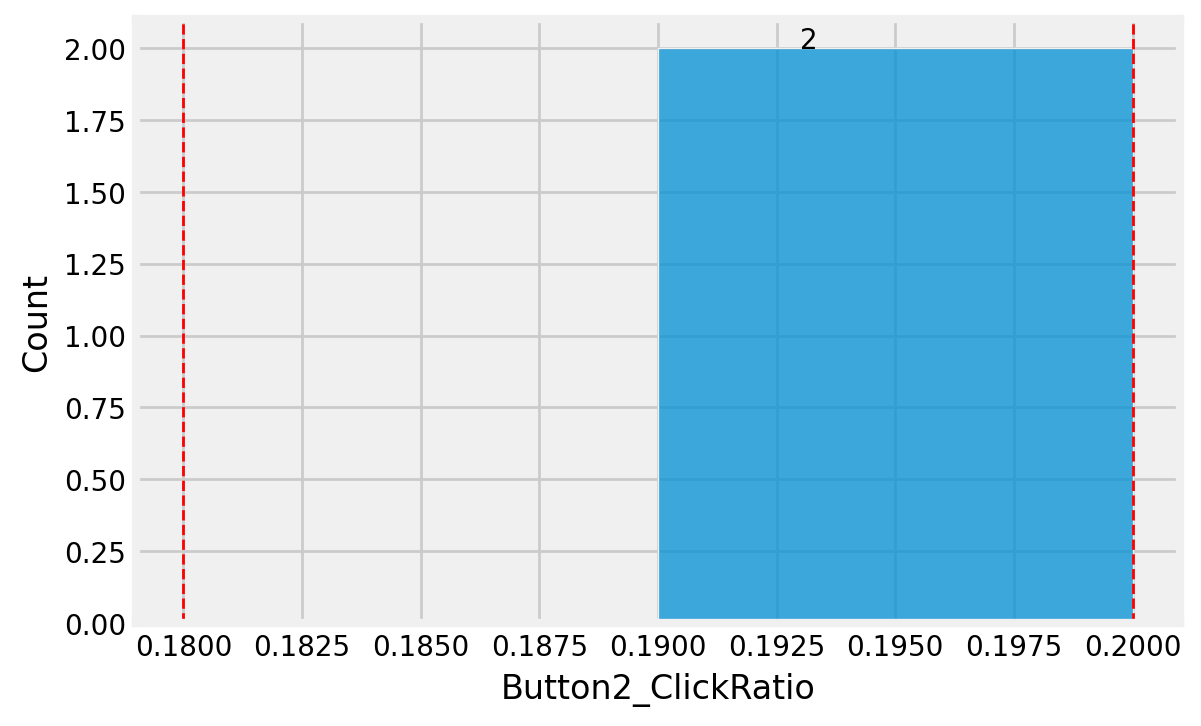

In [26]:
plt.figure(dpi=200)
ax = sns.histplot(data=click_drop[click_drop.failitem=='17'], x='Button2_ClickRatio', binwidth=0.01)
plt.axvline(0.2, color='red', ls='--', lw=1)
plt.axvline(0.18, color='red', ls='--',lw=1)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.003, p.get_height()))

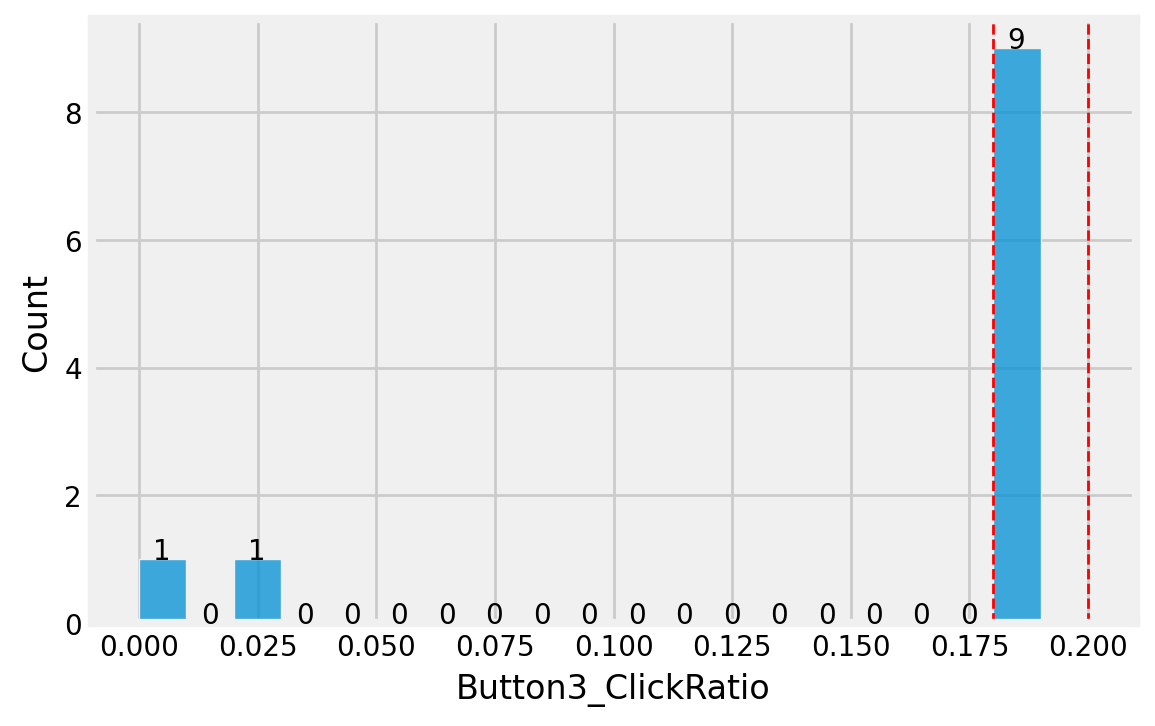

In [27]:
plt.figure(dpi=200)
ax = sns.histplot(data=click_drop[click_drop.failitem=='27'], x='Button3_ClickRatio', binwidth=0.01)
plt.axvline(0.2, color='red', ls='--', lw=1)
plt.axvline(0.18, color='red', ls='--',lw=1)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.003, p.get_height()))

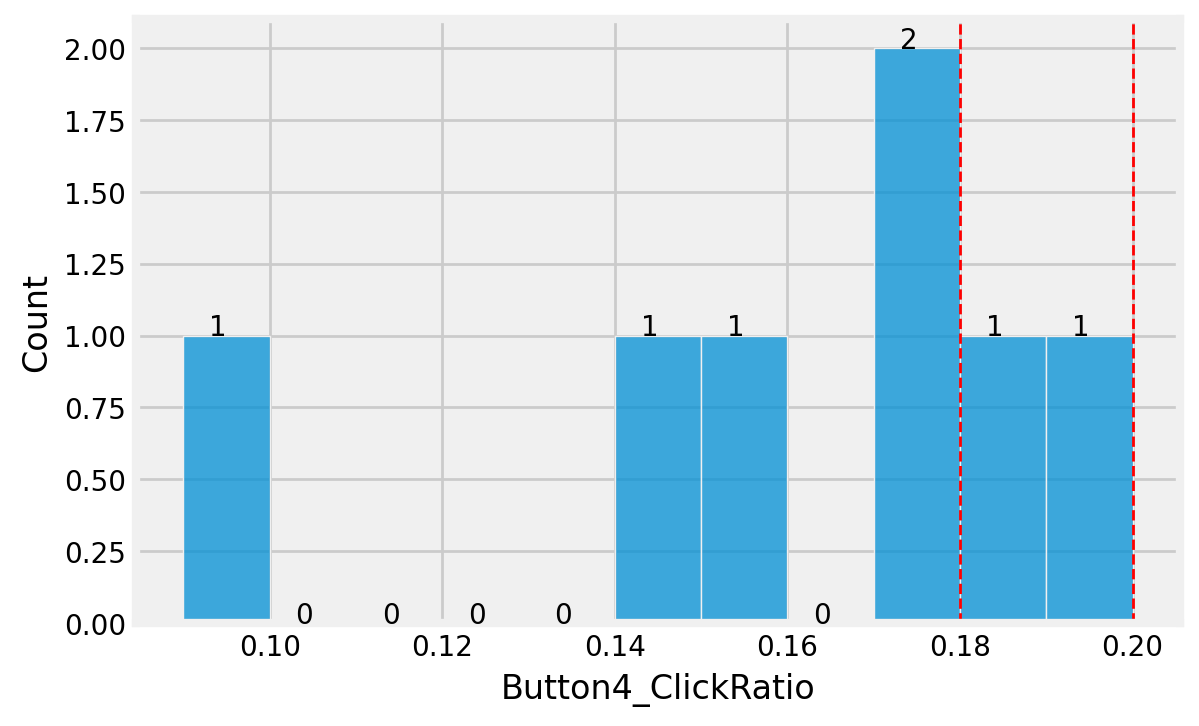

In [28]:
plt.figure(dpi=200)
ax2 = sns.histplot(data=click_drop[click_drop.failitem=='37'], x='Button4_ClickRatio', binwidth=0.01)

plt.axvline(0.2, color='red', ls='--', lw=1)
plt.axvline(0.18, color='red', ls='--', lw=1)
for p in ax2.patches:
        ax2.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.003, p.get_height()))